In [2]:
#initialization 
import matplotlib.pyplot as plt
import numpy as np

from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

#importing qiskit
from qiskit import IBMQ, Aer, assemble, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Operator

#import basic plot tools
from qiskit.visualization import plot_histogram

In [3]:
def XOR(qc, q1, q2, out):
    qc.cx(q1, out)
    qc.cx(q2, out)

In [9]:
def general_gate_diffuser(num_qubits):
    '''Return a diffuser for a given number of qubits built of gates'''
    qc = QuantumCircuit(num_qubits, name='gate-diffuser')
    qc.h(range(num_qubits))
    qc.x(range(num_qubits))
    # apply multi controlled Z gate
    qc.h(0)
    qc.mct(control_qubits=list(range(1,num_qubits)), target_qubit=0)
    qc.h(0)
    #qc.barrier()
    qc.x(range(num_qubits))
    qc.h(range(num_qubits))
    return qc

In [16]:
def sudoku_oracle(qc, check_pairs, condition_qubits, output_qubit):
    for i in range(4):
        XOR(qc, check_pairs[i][0], check_pairs[i][1], condition_qubits[i])
    # flip the output qubit if all conditions are satisfied
    qc.mct(condition_qubits, output_qubit)
    # uncompute condition qubits to reset them to 0
    for i in range(4):
        XOR(qc, check_pairs[i][0], check_pairs[i][1], condition_qubits[i])

In [17]:
check_pairs = [[0,1], [0,2], [1,3], [2,3]]
var_qubits = QuantumRegister(4, name='v')
condition_qubits = QuantumRegister(4, name='o')
output_qubit = QuantumRegister(1, name='output')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, condition_qubits, output_qubit, cbits, name='sudoku')

In [18]:
qc.initialize([1,-1]/np.sqrt(2), output_qubit)

qc.h(var_qubits)
qc.barrier()

sudoku_oracle(qc, check_pairs, condition_qubits, output_qubit)
qc.barrier()

qc.append(general_gate_diffuser(4), range(4))

qc.measure(var_qubits, cbits)

qc.draw(fold=-1)

┌───┐               ░                                                                                       ░ ┌────────────────┐┌─┐         
     v_0: ─────────────┤ H ├───────────────░───■─────────■──────────────────────────────────■─────────■────────────────────────────░─┤0               ├┤M├─────────
                       ├───┤               ░   │         │                                  │         │                            ░ │                │└╥┘┌─┐      
     v_1: ─────────────┤ H ├───────────────░───┼────■────┼─────────■────────────────────────┼────■────┼─────────■──────────────────░─┤1               ├─╫─┤M├──────
                       ├───┤               ░   │    │    │         │                        │    │    │         │                  ░ │  gate-diffuser │ ║ └╥┘┌─┐   
     v_2: ─────────────┤ H ├───────────────░───┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼─────────■────────░─┤2               ├─╫──╫─┤M├───
                       ├───┤               ░   │    │    │    │    │         │              │    │    │    │    │         │        ░ │                │ ║  ║ └╥┘┌─┐
     v_3: ─────────────┤ H ├───────────────░───┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼────■────┼────■───░─┤3               ├─╫──╫──╫─┤M├
                       └───┘               ░ ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ └────────────────┘ ║  ║  ║ └╥┘
     o_0: ─────────────────────────────────░─┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───░────────────────────╫──╫──╫──╫─
                                           ░ └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   ░                    ║  ║  ║  ║ 
     o_1: ─────────────────────────────────░───────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼────┼────┼────┼───░────────────────────╫──╫──╫──╫─
                                           ░           └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░                    ║  ║  ║  ║ 
     o_2: ─────────────────────────────────░─────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├┤ X ├──┼────┼───░────────────────────╫──╫──╫──╫─
                                           ░                     └───┘└───┘┌─┴─┐┌─┴─┐  │                      └───┘└───┘┌─┴─┐┌─┴─┐ ░                    ║  ║  ║  ║ 
     o_3: ─────────────────────────────────░───────────────────────────────┤ X ├┤ X ├──■────────────────────────────────┤ X ├┤ X ├─░────────────────────╫──╫──╫──╫─
          ┌──────────────────────────────┐ ░                               └───┘└───┘┌─┴─┐                              └───┘└───┘ ░                    ║  ║  ║  ║ 
output_0: ┤ initialize(0.70711,-0.70711) ├─░─────────────────────────────────────────┤ X ├─────────────────────────────────────────░────────────────────╫──╫──╫──╫─
          └──────────────────────────────┘ ░                                         └───┘                                         ░                    ║  ║  ║  ║ 
 cbits: 4/══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                                                                                        0  1  2  3

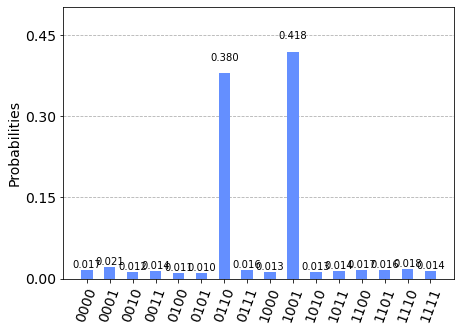

In [20]:
simulator = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, simulator)
obj = assemble(transpiled_qc)
result = simulator.run(obj).result()
plot_histogram(result.get_counts())